In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch, find_peaks, hilbert
from scipy.integrate import odeint

# === Load EEG data (replace with your path) ===
file_path = "/Users/kasunachinthaperera/Documents/VS Code/Complex Network/Data/EEG.csv"
EEG = pd.read_csv(file_path)

real_data_path = "/Users/kasunachinthaperera/Documents/VS Code/Complex Network/Data/Epileptogenic_Results.csv"
df = pd.read_csv(real_data_path)


/var/folders/b9/x77syzb94gdggfcpp713pvjm0000gn/T/ipykernel_43797/1066117603.py:21: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwt_matrix = cwt(signal, morlet2, widths=[width], w=bandwidth)


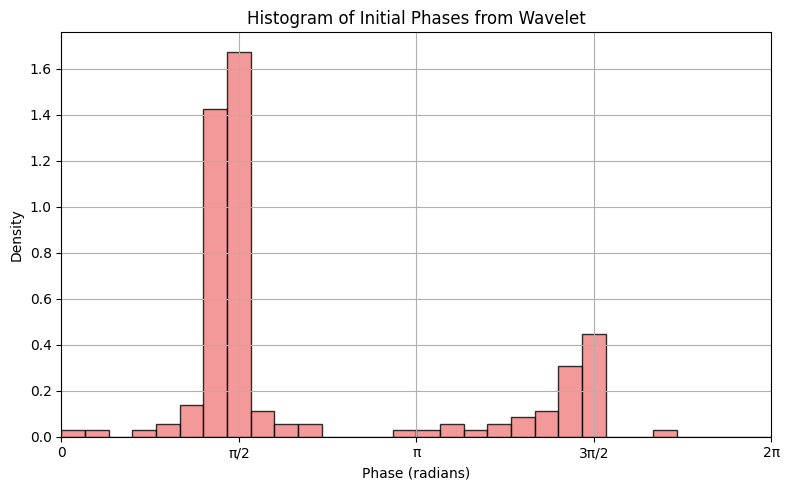

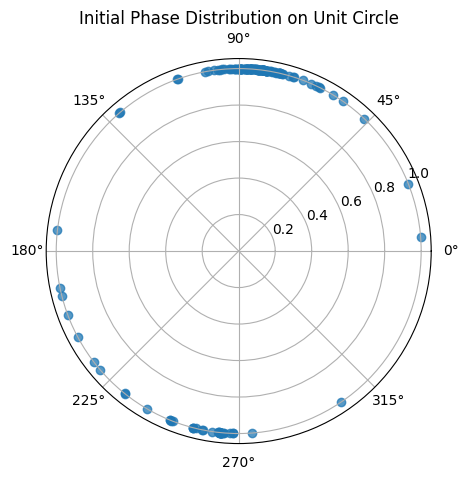

In [8]:
# Epileptogenic comparison from real EEG data - Wavelet Phase Method
import numpy as np
import pandas as pd
from scipy.signal import cwt, morlet2

# === Parameters ===
epsilon = 1  # Coupling strength
fs = 500     # Sampling rate
target_freq = 10  # Frequency of interest (e.g., alpha band center)
bandwidth = 5.0   # Bandwidth parameter for Morlet wavelet
channels = EEG.columns
N = len(channels)

# === Step 1: Get initial phases using Wavelet Transform ===
initial_phases = []
for channel in EEG.columns:
    signal = EEG[channel].values
    width = fs / (2 * np.pi * target_freq)  # Wavelet width for center frequency

    # Apply continuous wavelet transform using complex Morlet wavelet
    cwt_matrix = cwt(signal, morlet2, widths=[width], w=bandwidth)
    wavelet_coeff = cwt_matrix[0]

    # Phase is the angle of complex wavelet coefficient
    phase = np.angle(wavelet_coeff)
    wrapped_phase = np.mod(phase[0], 2 * np.pi)  # Take initial phase, wrap to [0, 2π]
    initial_phases.append(wrapped_phase)

initial_phases = np.array(initial_phases)
x = np.array(initial_phases)  # Initial phases (fixed during TLE calculation)

# Wrap phase values to the range [0, 2π)
x = np.mod(x, 2 * np.pi)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(x, bins=30, density=True, color='lightcoral', edgecolor='black', alpha=0.8, range=(0, 2*np.pi))
plt.title("Histogram of Initial Phases from Wavelet")
plt.xlabel("Phase (radians)")
plt.ylabel("Density")
plt.xlim([0, 2*np.pi])
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ['0', 'π/2', 'π', '3π/2', '2π'])
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Polar plot of final wrapped phases ===
plt.figure(figsize=(5, 5))
ax = plt.subplot(111, polar=True)
ax.scatter(x, np.ones_like(x), alpha=0.75)
ax.set_title(f'Initial Phase Distribution on Unit Circle')
plt.show()


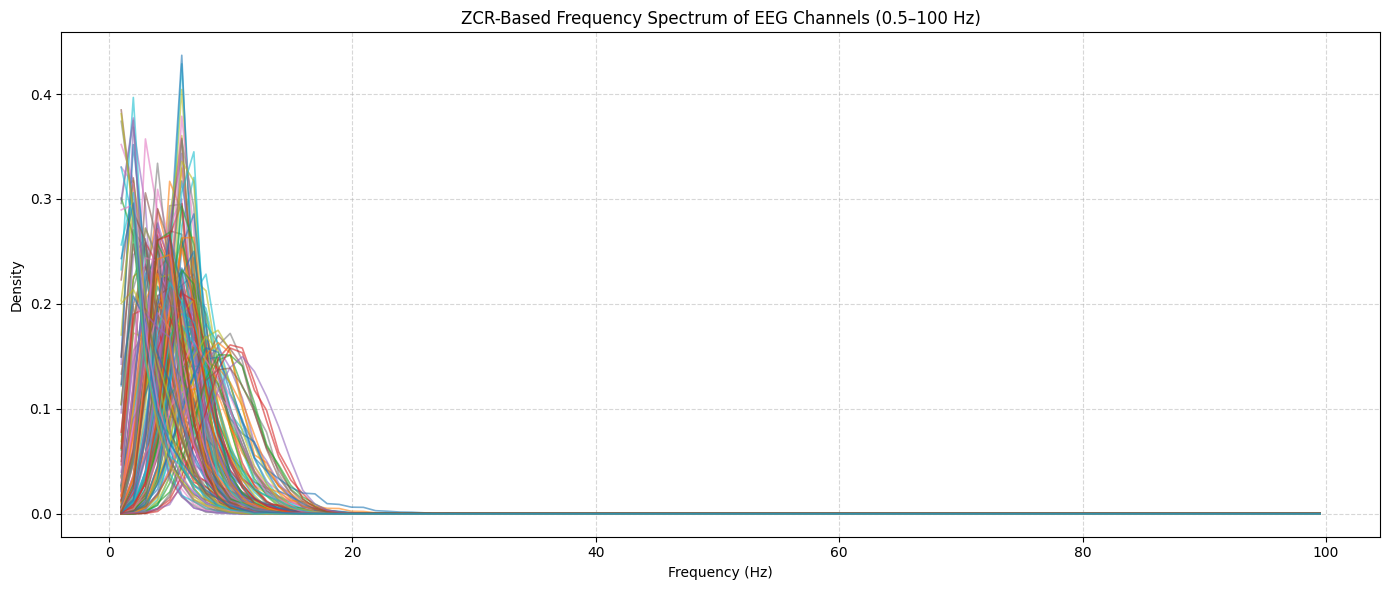

Estimated g(0): 0.1650
Critical coupling ε_c ≈ 3.8572


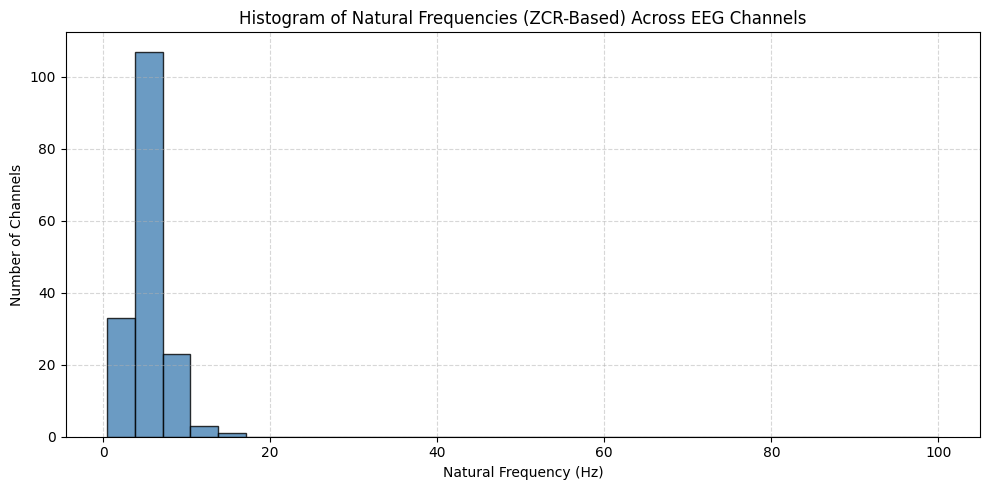

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde

# === ZCR-based frequency estimator ===
def natural_frequency_zcr(signal, fs):
    signal = signal - np.mean(signal)
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    num_crossings = len(zero_crossings)
    duration_sec = len(signal) / fs
    freq = (num_crossings / 2) / duration_sec
    return freq

# === Parameters ===
fs = 500                 # Sampling frequency
win_len_sec = 2          # Window length in seconds
win_len = int(win_len_sec * fs)
step_len = int(0.5 * fs) # Overlap of 50%
freq_range = (0.5, 100)
bins = 100

natural_frequencies = []

# === Plot frequency spectra for each EEG channel ===
plt.figure(figsize=(14, 6))

for ch in EEG.columns:
    signal = EEG[ch].values
    freqs = []

    for start in range(0, len(signal) - win_len, step_len):
        window = signal[start:start + win_len]
        f = natural_frequency_zcr(window, fs)
        if freq_range[0] <= f <= freq_range[1]:
            freqs.append(f)

    # Plot histogram (density spectrum)
    hist_vals, bin_edges = np.histogram(freqs, bins=bins, range=freq_range, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(bin_centers, hist_vals, alpha=0.6, lw=1.2, label=ch)

    # Detect peak frequency as natural frequency
    peaks, _ = find_peaks(hist_vals)
    if len(peaks) > 0:
        peak_idx = peaks[np.argmax(hist_vals[peaks])]
        nat_freq = bin_centers[peak_idx]
    else:
        nat_freq = 0.0

    natural_frequencies.append(nat_freq)

plt.title("ZCR-Based Frequency Spectrum of EEG Channels (0.5–100 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === Step 2: Estimate g(0) and critical coupling ε_c ===
natural_frequencies = np.array(natural_frequencies)
omega = natural_frequencies

# Estimate g(0) using Gaussian KDE
kde = gaussian_kde(omega)
density_values = kde.evaluate(omega)
g_omega = np.max(density_values)
epsilon_critical = 2 / (np.pi * g_omega)

print(f"Estimated g(0): {g_omega:.4f}")
print(f"Critical coupling ε_c ≈ {epsilon_critical:.4f}")

# === Plot histogram of natural frequencies across channels ===
plt.figure(figsize=(10, 5))
plt.hist(natural_frequencies, bins=30, range=freq_range, alpha=0.8, color='steelblue', edgecolor='black')
plt.title("Histogram of Natural Frequencies (ZCR-Based) Across EEG Channels")
plt.xlabel("Natural Frequency (Hz)")
plt.ylabel("Number of Channels")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Estimated g(omega): 0.1650
Critical coupling ε_c ≈ 3.8572


/var/folders/b9/x77syzb94gdggfcpp713pvjm0000gn/T/ipykernel_43797/2931673870.py:73: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwt_matrix = cwt(signal, morlet2, widths=[width], w=bandwidth)


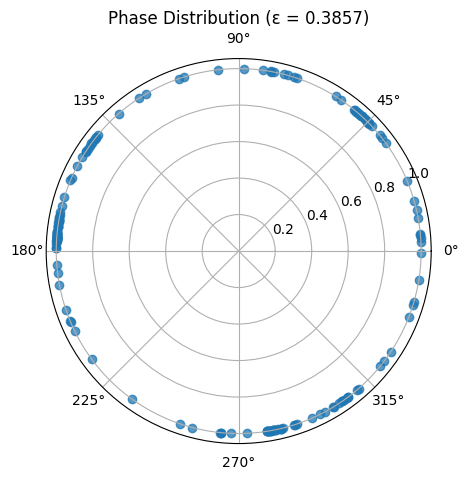

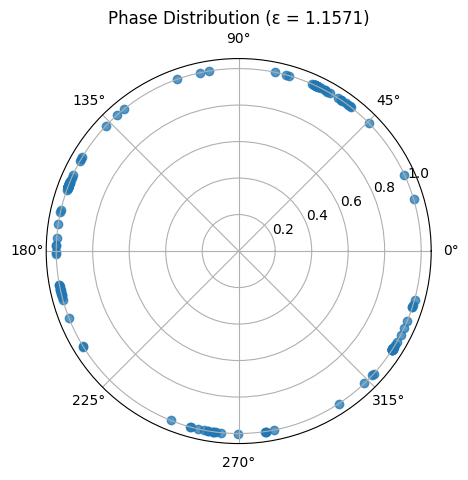

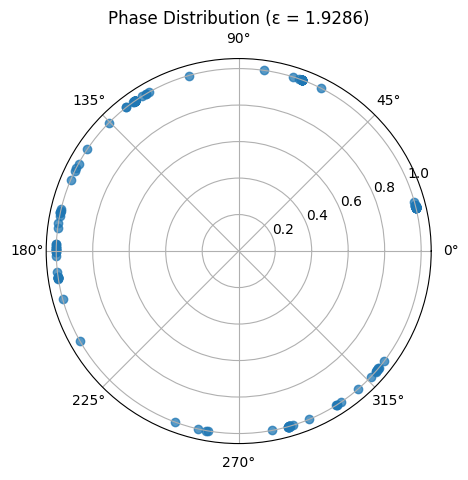

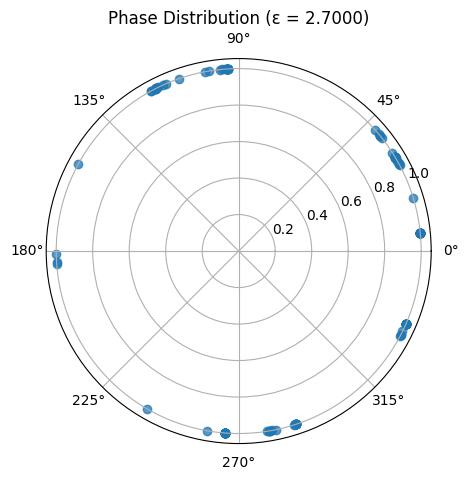

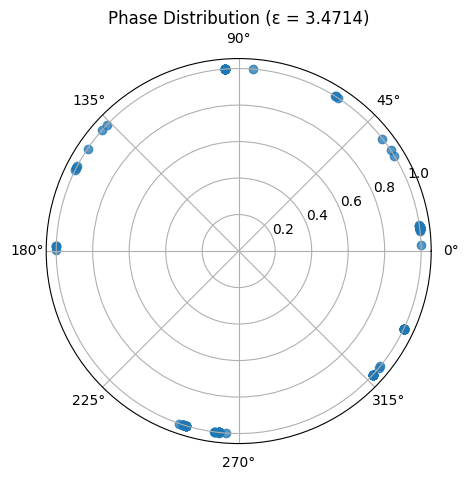

In [10]:
# Zero-Crossing Rate based frequency kuramoto model simulation - 05
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

# === Zero-Crossing Rate based frequency estimator ===
def natural_frequency_zcr(signal, fs):
    signal = signal - np.mean(signal)
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    num_crossings = len(zero_crossings)
    duration_sec = len(signal) / fs
    freq = (num_crossings / 2) / duration_sec
    return freq

# === Parameters ===
fs = 500                 # Sampling frequency
win_len_sec = 2          # Window length in seconds
win_len = int(win_len_sec * fs)
step_len = int(0.5 * fs) # Overlap of 50%
freq_range = (0.5, 100)
bins = 100
T_sim = 1500  # Number of time steps for simulation
dt = 0.01  # Time step size

# === Storage for natural frequencies ===
natural_frequencies = []

# === Compute natural frequencies per EEG channel ===
for ch in EEG.columns:
    signal = EEG[ch].values
    freqs = []

    for start in range(0, len(signal) - win_len, step_len):
        window = signal[start:start + win_len]
        f = natural_frequency_zcr(window, fs)
        if freq_range[0] <= f <= freq_range[1]:
            freqs.append(f)

    # Build histogram for this channel to find peak frequency
    hist_vals, bin_edges = np.histogram(freqs, bins=bins, range=freq_range, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Detect peak of the histogram
    peaks, _ = find_peaks(hist_vals)
    if len(peaks) > 0:
        peak_idx = peaks[np.argmax(hist_vals[peaks])]
        nat_freq = bin_centers[peak_idx]
    else:
        nat_freq = 0.0

    natural_frequencies.append(nat_freq)

omega = natural_frequencies  # frequency vector

# Estimate g(0) using Gaussian KDE
kde = gaussian_kde(omega)
density_values = kde.evaluate(omega)
g_omega = np.max(density_values)
epsilon_critical = 2 / (np.pi * g_omega)

print(f"Estimated g(omega): {g_omega:.4f}")
print(f"Critical coupling ε_c ≈ {epsilon_critical:.4f}")

# === Step 3: Simulate Kuramoto model ===
epsilons = np.linspace(0.1 * epsilon_critical, 0.9 * epsilon_critical, 5)

initial_phases = []
for channel in EEG.columns:
    signal = EEG[channel].values
    width = fs / (2 * np.pi * target_freq)  # Wavelet width for center frequency

    # Apply continuous wavelet transform using complex Morlet wavelet
    cwt_matrix = cwt(signal, morlet2, widths=[width], w=bandwidth)
    wavelet_coeff = cwt_matrix[0]

    # Phase is the angle of complex wavelet coefficient
    phase = np.angle(wavelet_coeff)
    wrapped_phase = np.mod(phase[0], 2 * np.pi)  # Take initial phase, wrap to [0, 2π]
    initial_phases.append(wrapped_phase)

initial_phases = np.array(initial_phases)

# === Simulation ===
for epsilon in epsilons:
    x = np.copy(initial_phases)
    phase_history = np.zeros((T_sim, N))
    phase_history[0] = x

    for t in range(1, T_sim):
        x_new = np.copy(x)
        for k in range(N):
            coupling_sum = np.sum(np.sin(x - x[k]))
            x_new[k] += dt * (omega[k] + (epsilon / N) * coupling_sum)
        x = x_new
        phase_history[t] = x

    time = np.arange(T_sim) * dt

    

    # === Plot 2: Final phase distribution in polar plot ===
    final_phases = phase_history[-1]
    plt.figure(figsize=(5, 5))
    ax = plt.subplot(111, polar=True)
    ax.scatter(final_phases % (2*np.pi), np.ones_like(final_phases), alpha=0.75)
    ax.set_title(f'Phase Distribution (ε = {epsilon:.4f})')
    plt.show()

   


In [11]:
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.utils import resample

# Assuming `omega` is your array of natural frequencies
n_bootstraps = 1000
g_omega_values = []

# Bootstrap resampling
for _ in range(n_bootstraps):
    omega_sample = resample(omega)
    kde = gaussian_kde(omega_sample)
    density_values = kde.evaluate(omega_sample)
    g_omega_values.append(np.max(density_values))

g_omega_values = np.array(g_omega_values)
g_omega_mean = np.mean(g_omega_values)
g_omega_std = np.std(g_omega_values)

epsilon_critical_values = 2 / (np.pi * g_omega_values)
epsilon_critical_mean = np.mean(epsilon_critical_values)
epsilon_critical_std = np.std(epsilon_critical_values)

print(f"Estimated g(omega): {g_omega_mean:.4f} ± {g_omega_std:.4f}")
print(f"Critical coupling ε_c ≈ {epsilon_critical_mean:.4f} ± {epsilon_critical_std:.4f}")


Estimated g(omega): 0.1698 ± 0.0135
Critical coupling ε_c ≈ 3.7732 ± 0.2942


In [12]:
# Epileptogenic comparison from real EEG data - Wavelet Phase Method
import numpy as np
import pandas as pd
from scipy.signal import cwt, morlet2

# === Parameters ===
epsilon = 0.5 * epsilon_critical  # Coupling strength
fs = 500     # Sampling rate
target_freq = 10  # Frequency of interest (e.g., alpha band center)
bandwidth = 5.0   # Bandwidth parameter for Morlet wavelet
channels = EEG.columns
N = len(channels)

# === Step 1: Get initial phases using Wavelet Transform ===
initial_phases = []
for channel in EEG.columns:
    signal = EEG[channel].values
    width = fs / (2 * np.pi * target_freq)  # Wavelet width for center frequency

    # Apply continuous wavelet transform using complex Morlet wavelet
    cwt_matrix = cwt(signal, morlet2, widths=[width], w=bandwidth)
    wavelet_coeff = cwt_matrix[0]

    # Phase is the angle of complex wavelet coefficient
    phase = np.angle(wavelet_coeff)
    wrapped_phase = np.mod(phase[0], 2 * np.pi)  # Take initial phase, wrap to [0, 2π]
    initial_phases.append(wrapped_phase)

initial_phases = np.array(initial_phases)
x = np.array(initial_phases)  # Initial phases (fixed during TLE calculation)

# === Step 2: Compute TLEs for each channel ===
TLEs = np.zeros(N)
for k in range(N):
    cos_sum = 0
    for j in range(N):
        if j != k:
            cos_sum += np.cos(x[j] - x[k])
    TLEs[k] = - (epsilon / N) * cos_sum

# === Step 3: Threshold TLEs to determine simulated epileptogenicity ===
Epileptogenic_simulated = (TLEs <= 0).astype(int)
Epileptogenic_sim = np.column_stack((channels, Epileptogenic_simulated.astype(str)))

# === Step 4: Load real labels from CSV ===
file_path = "/Users/kasunachinthaperera/Documents/VS Code/Complex Network/Data/Epileptogenic_Results.csv"
df = pd.read_csv(file_path)

Epileptogenic_real = np.column_stack((channels, df['Epileptogenic'].astype(str)))

# === Step 5: Cross-tabulation of simulation vs real labels ===
sim_vals = Epileptogenic_sim[:, 1].astype(int)
real_vals = Epileptogenic_real[:, 1].astype(int)

cross_table = np.zeros((2, 2), dtype=int)
for s, r in zip(sim_vals, real_vals):
    cross_table[s, r] += 1

# Format using pandas for readability
df_cross = pd.DataFrame(cross_table,
                        index=['Sim=0 (Non-Epi)', 'Sim=1 (Epi)'],
                        columns=['Real=0 (Non-Epi)', 'Real=1 (Epi)'])

print("\nCross-tabulation Results using ZCR and WT (Simulated vs Real Epileptogenicity):")
print(df_cross)


/var/folders/b9/x77syzb94gdggfcpp713pvjm0000gn/T/ipykernel_43797/2075852420.py:21: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwt_matrix = cwt(signal, morlet2, widths=[width], w=bandwidth)



Cross-tabulation Results using ZCR and WT (Simulated vs Real Epileptogenicity):
                 Real=0 (Non-Epi)  Real=1 (Epi)
Sim=0 (Non-Epi)                30            11
Sim=1 (Epi)                    89            41
